In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd+'/../')

In [38]:
def plot_metrics(pruning_method='energy', arch = 'LeNet_5', stage = '0', NVM_COST=100):
    prefix = 'logs/{}/{}/stage_{}'.format(pruning_method, arch, stage)
    paths = [prefix+'.csv', prefix+'_pruning_order.csv', prefix+'_search_history.csv']
    df_0 = pd.read_csv(paths[0])
    df_1 = pd.read_csv(paths[1])
    df_2 = pd.read_csv(paths[2])
    df_data = df_0.loc[:, 'nvm_read_inputs':'vm_write_psum']
    df_energy_cost = df_data.copy()
    if pruning_method == 'energy':
        nvm = ['nvm_read_inputs', 'nvm_read_weights', 'nvm_jobs']
    elif pruning_method == 'intermittent':
        nvm = ['nvm_read_inputs', 'nvm_read_weights', 'nvm_jobs', 'nvm_read_psum', 'nvm_write_psum']
        df_energy_cost['nvm_read_psum'] = df_energy_cost['vm_read_psum']
        df_energy_cost['nvm_write_psum'] = df_energy_cost['vm_write_psum']
        df_energy_cost['nvm_jobs'] = df_energy_cost['vm_jobs']
    print(df_energy_cost)
        
    for item in nvm:
        df_energy_cost[item] = df_energy_cost[item] * NVM_COST

    df_energy_cost.plot(kind="bar",stacked=True,figsize=(10,8))
    plt.show()

    inputs_cost = df_energy_cost['nvm_read_inputs'] + df_energy_cost['vm_read_inputs']
    weights_cost = df_energy_cost['nvm_read_weights'] + df_energy_cost['vm_read_weights']
    if pruning_method == 'energy':
        psum_cost = df_energy_cost['nvm_jobs'] + df_energy_cost['vm_jobs'] + df_energy_cost['vm_read_psum'] + df_energy_cost['vm_write_psum']
    elif pruning_method == 'intermittent':
        psum_cost = df_energy_cost['nvm_jobs'] + df_energy_cost['nvm_read_psum'] + df_energy_cost['nvm_write_psum'] + df_energy_cost['vm_jobs'] + df_energy_cost['vm_read_psum'] + df_energy_cost['vm_write_psum']
    
    df_energy_class = pd.DataFrame()
    df_energy_class['inputs_cost'] = inputs_cost
    df_energy_class['weights_cost'] = weights_cost
    df_energy_class['psum_cost'] = psum_cost

    # add percenetage of each part
    df_total = 0
    for item in df_energy_class:
        df_total += df_energy_class[item]
    df_rel = df_energy_class[df_energy_class.columns[:]].div(df_total, 0) * 100

    print(df_rel)

    df_energy_class.plot(kind="bar",stacked=True,figsize=(10,8),title='Energy Cost Class')

    for n in df_rel:
        for i, (cs, ab, pc) in enumerate(zip(df_energy_class.iloc[:,:].cumsum(1)[n],df_energy_class[n], df_rel[n])):
            plt.text(i, cs - ab / 2, str(np.round(pc, 1)) + '%',va = 'center', ha = 'center')

    print('Pruning Order:')
    print(df_1)

In [41]:
pruning_method = 'energy'
arch = 'LeNet_5'

   nvm_read_inputs  nvm_read_weights  nvm_jobs  vm_jobs  vm_read_weights  \
0           3920.0               208      6272    81536           163072   
1           7840.0              3200      3136   313600           627200   
2           1024.0             65536       256    32768            65536   
3            256.0              2560        10     1280             2560   

   vm_read_inputs  vm_read_psum  vm_write_psum  
0          163072        150528          75264  
1          627200        620928         310464  
2           65536         65024          32512  
3            2560          2540           1270  


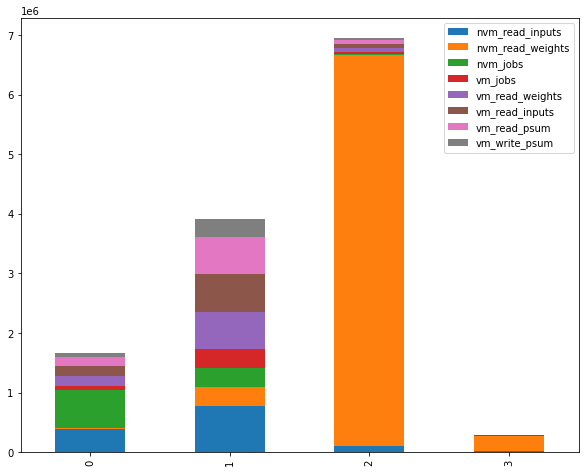

   inputs_cost  weights_cost  psum_cost
0    33.168885     10.987456  55.843659
1    36.027646     24.181821  39.790533
2     2.418790     95.335718   2.245492
3     9.617158     88.302995   2.079847
Pruning Order:
   0  1  2  3
0  3  0  1  2


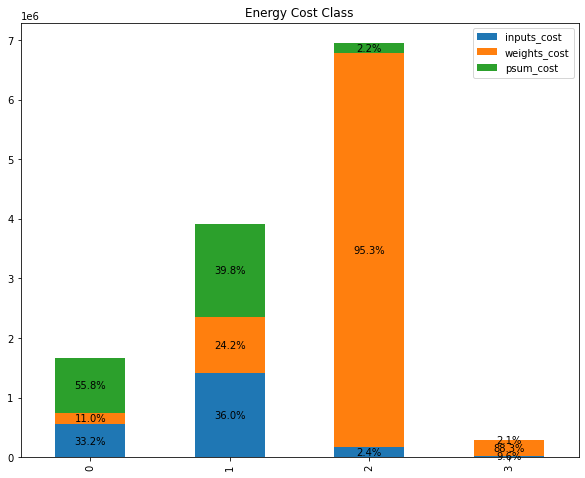

In [42]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='0')

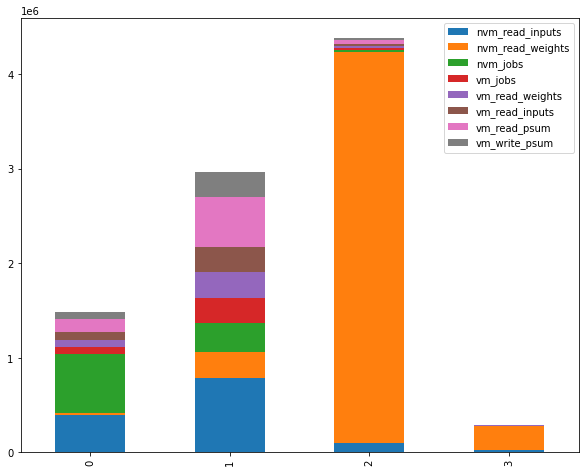

   inputs_cost  weights_cost  psum_cost
0    31.605244      6.556115  61.838641
1    35.447973     18.221891  46.330137
2     2.809072     94.738680   2.452248
3     9.260982     88.640827   2.098191
Pruning Order:
   0  1  2  3
0  3  0  1  2


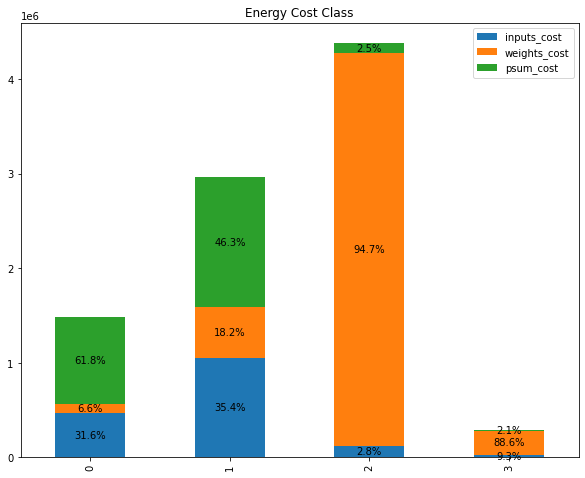

In [26]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='1')

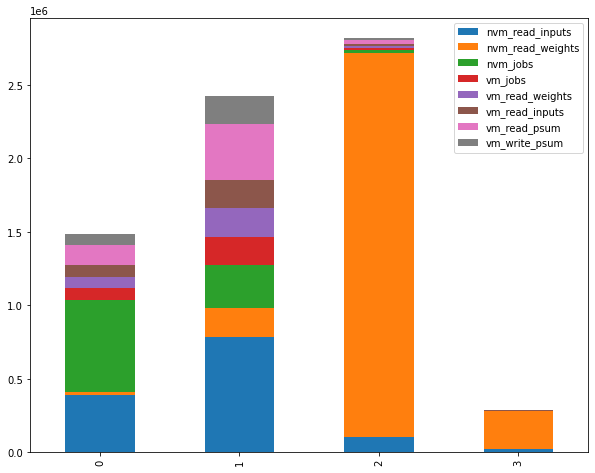

   inputs_cost  weights_cost  psum_cost
0    31.605244      6.556115  61.838641
1    40.284000     16.095199  43.620801
2     4.097297     93.167433   2.735269
3     9.260982     88.640827   2.098191
Pruning Order:
   0  1  2  3
0  3  0  1  2


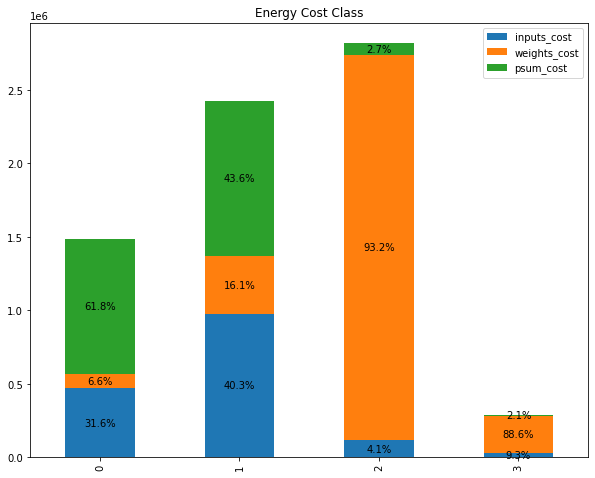

In [27]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='2')

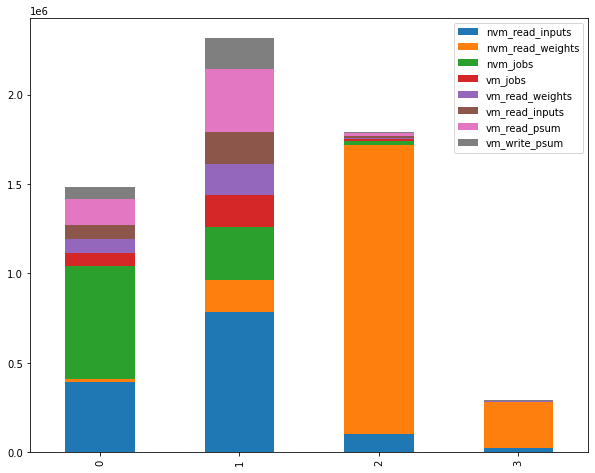

   inputs_cost  weights_cost  psum_cost
0    31.605244      6.556115  61.838641
1    41.537983     15.484389  42.977628
2     6.170876     90.734024   3.095101
3     9.260982     88.640827   2.098191
Pruning Order:
   0  1  2  3
0  3  0  2  1


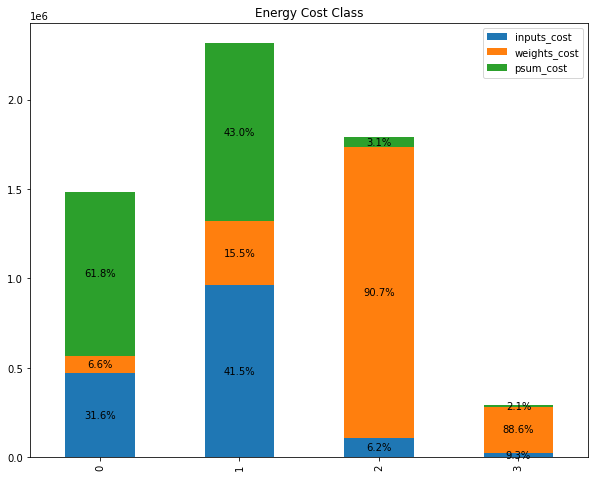

In [28]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='3')

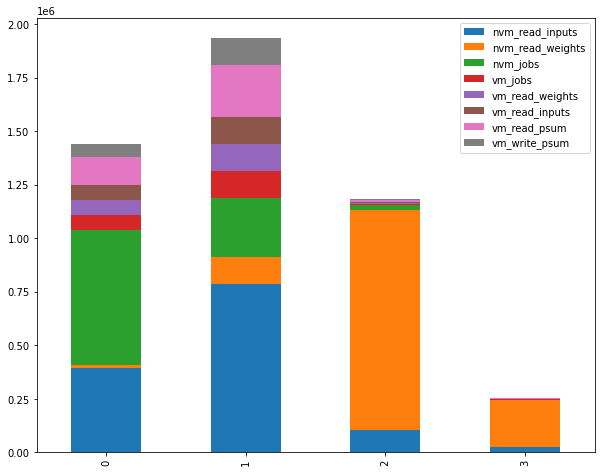

   inputs_cost  weights_cost  psum_cost
0    32.083366      6.142561  61.774074
1    47.054759     13.148389  39.796851
2     9.076463     87.391673   3.531864
3    10.546273     87.332622   2.121104
Pruning Order:
   0  1  2  3
0  3  2  0  1


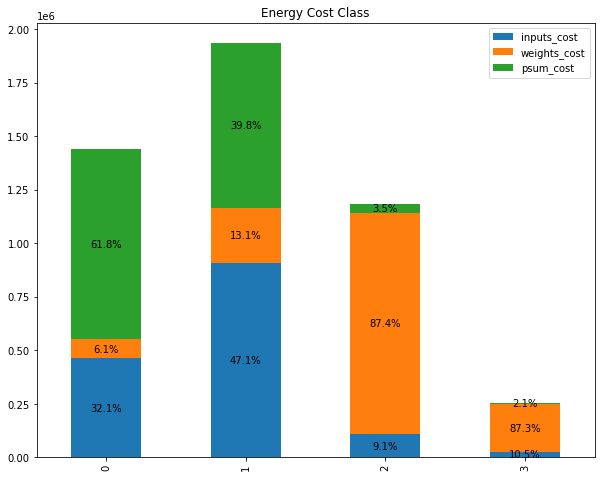

In [29]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='4')

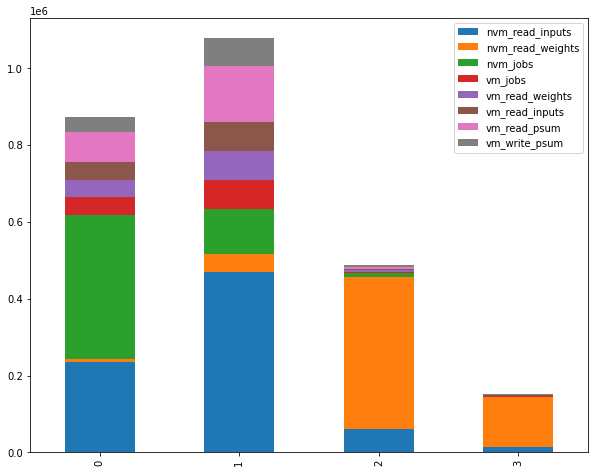

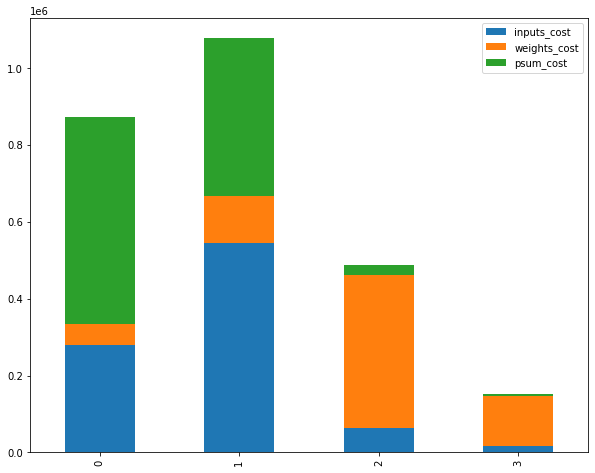

In [11]:
plot_metrics(pruning_method=pruning_method, arch=arch, stage='5')